# Task 2 - Bayesian Change Point Modeling (PyMC)

This notebook fits a core Bayesian change point model to Brent oil time series (log returns):
- EDA recap (price + returns)
- Fit a single change point model with PyMC
- Diagnose convergence and interpret posterior
- Associate detected change point with nearest curated event

Exports:
- `models/changepoint_summary.json`
- posterior plots to `reports/figures/`

In [12]:
import json
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# Project root (works whether launched from repo root or notebooks/)
ROOT = Path.cwd().resolve()
if not (ROOT / 'data').exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Reload local modules to pick up edits without restarting the kernel
import importlib
import src.data as data_mod
import src.changepoint as cp_mod
importlib.reload(data_mod)
importlib.reload(cp_mod)

from src.data import load_brent_prices, load_events, compute_log_returns
from src.changepoint import (
    fit_single_changepoint_normal,
    build_summary,
    summary_to_dict,
    nearest_event,
 )

FIG_DIR = ROOT / 'reports' / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = ROOT / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
az.style.use('arviz-darkgrid')

In [21]:
prices_full = load_brent_prices()
events = load_events()

# Focus on the last decade (aligns with the project brief)
cutoff = prices_full['Date'].max() - pd.DateOffset(years=10)
prices = prices_full.loc[prices_full['Date'] >= cutoff].reset_index(drop=True)

prices[['Date','Price']].head()

,Date,Price
0,2012-11-14,109.66
1,2012-11-15,110.07
2,2012-11-16,106.81
3,2012-11-19,110.06
4,2012-11-20,110.01


In [14]:
returns = compute_log_returns(prices['Price'])
dates_returns = prices['Date'].iloc[1:].reset_index(drop=True)
# Standardize returns for the Normal likelihood
y = (returns.values - returns.values.mean()) / returns.values.std()
len(y), y.mean(), y.std()

(2542, np.float64(-1.1180845566642017e-17), np.float64(1.0))

## Fit single change point model
We model a single structural break in the mean and volatility of standardized returns.

In [15]:
idata = fit_single_changepoint_normal(y, draws=1000, tune=1000, chains=2, target_accept=0.92)
az.summary(idata, var_names=['tau','mu_before','mu_after','sigma_before','sigma_after'])

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_before, mu_after, sigma_before, sigma_after]


/home/aln_lvr/Desktop/Courses/KAIM/B8W11/Change-Point-Analysis-and-Statistical-Modeling-W11/.venv/lib/python3.14/si
te-packages/rich/live.py:260: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,1526.638,6.469,1514.000,1538.000,0.558,0.379,157.0,256.0,1.0
mu_before,-0.009,0.017,-0.040,0.025,0.000,0.000,2200.0,1556.0,1.0
mu_after,0.014,0.043,-0.064,0.095,0.001,0.001,2361.0,1749.0,1.0
sigma_before,0.641,0.012,0.619,0.663,0.000,0.000,1853.0,1274.0,1.0
sigma_after,1.375,0.031,1.319,1.434,0.001,0.001,1953.0,1322.0,1.0


/tmp/ipykernel_26242/2811652068.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


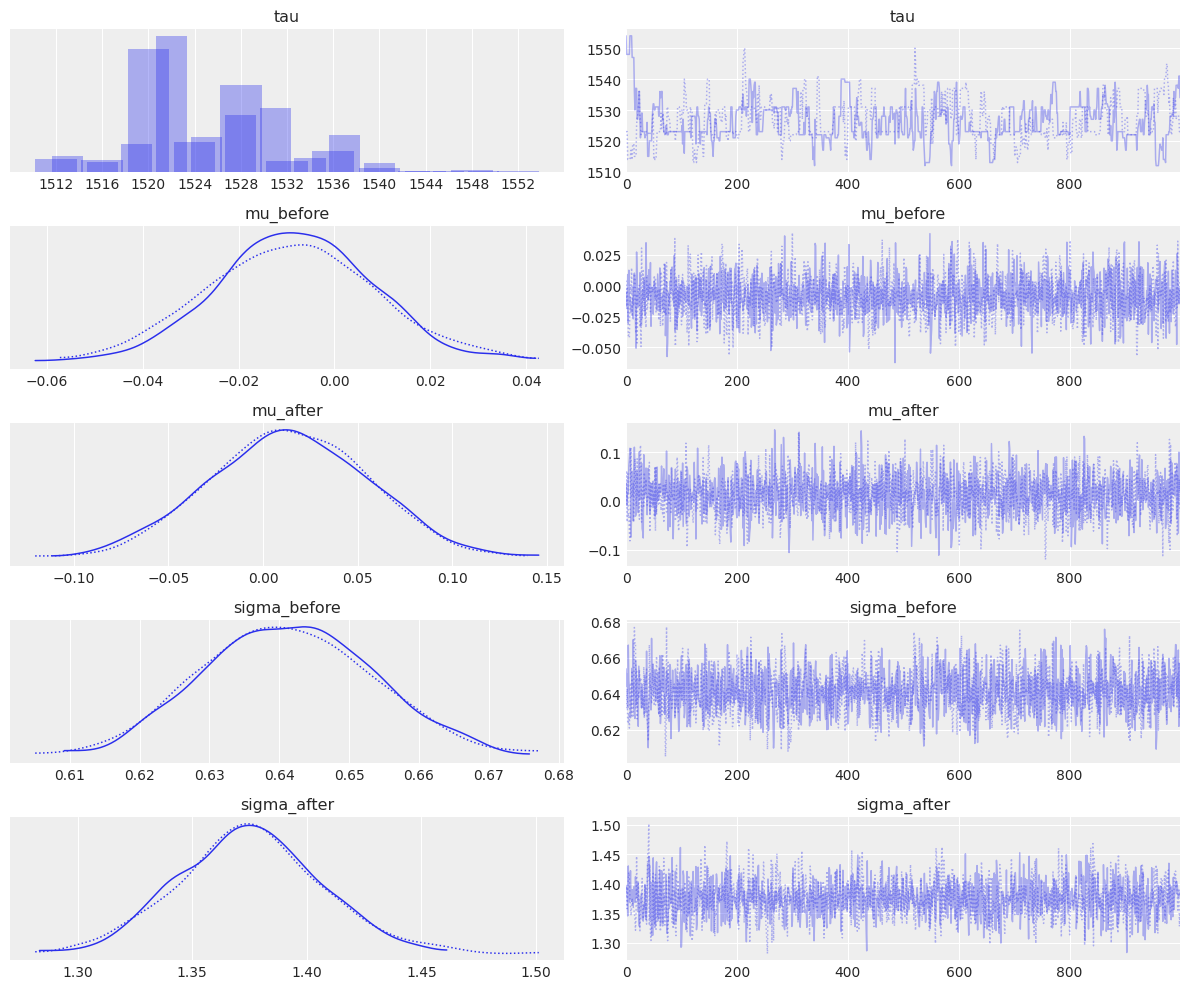

PosixPath('/home/aln_lvr/Desktop/Courses/KAIM/B8W11/Change-Point-Analysis-and-Statistical-Modeling-W11/reports/figures/trace_changepoint.png')

In [16]:
az.plot_trace(idata, var_names=['tau','mu_before','mu_after','sigma_before','sigma_after']);
out = FIG_DIR / 'trace_changepoint.png'
plt.tight_layout()
plt.savefig(out, dpi=160)
plt.show()
out

/tmp/ipykernel_26242/2865551632.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


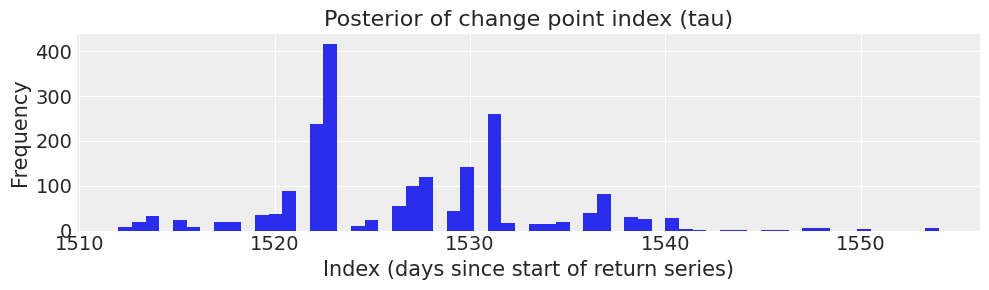

PosixPath('/home/aln_lvr/Desktop/Courses/KAIM/B8W11/Change-Point-Analysis-and-Statistical-Modeling-W11/reports/figures/posterior_tau_hist.png')

In [17]:
tau_samples = idata.posterior['tau'].values.reshape(-1)
plt.figure(figsize=(10, 3))
plt.hist(tau_samples, bins=60)
plt.title('Posterior of change point index (tau)')
plt.xlabel('Index (days since start of return series)')
plt.ylabel('Frequency')
plt.tight_layout()
out = FIG_DIR / 'posterior_tau_hist.png'
plt.savefig(out, dpi=160)
plt.show()
out

In [18]:
summary = build_summary(idata, dates=dates_returns)
summary

ChangePointSummary(tau_index_median=1526, tau_index_hdi_94=(1514, 1538), tau_date_median='2018-11-15', tau_date_hdi_94=('2018-10-30', '2018-12-03'), mu_before_mean=-0.008571311030504212, mu_after_mean=0.013742202364248233, sigma_before_mean=0.6412532856382038, sigma_after_mean=1.3749199018220506, prob_mu_after_gt_before=0.6895)

In [19]:
# Simple impact quantification in USD terms around the detected change point
tau_idx = int(summary.tau_index_median)  # index in the returns series (aligned to prices[1:])
window = 90
prices_aligned = prices.iloc[1:].reset_index(drop=True).copy()
pre = prices_aligned.iloc[max(0, tau_idx - window):tau_idx]
post = prices_aligned.iloc[tau_idx: min(len(prices_aligned), tau_idx + window)]

impact_stats = {
    'window_days': window,
    'pre_mean_price_usd': float(pre['Price'].mean()) if len(pre) else None,
    'post_mean_price_usd': float(post['Price'].mean()) if len(post) else None,
}
if impact_stats['pre_mean_price_usd'] and impact_stats['post_mean_price_usd']:
    impact_stats['pct_change_mean_price'] = float(100 * (impact_stats['post_mean_price_usd'] - impact_stats['pre_mean_price_usd']) / impact_stats['pre_mean_price_usd'])
impact_stats

{'window_days': 90,
 'pre_mean_price_usd': 75.84055555555555,
 'post_mean_price_usd': 61.62800000000001,
 'pct_change_mean_price': -18.74004673547573}

In [22]:
nearest = nearest_event(target_date=summary.tau_date_median, events=events, max_days=60)
print(nearest)
nearest

{'event_date': '2018-11-05', 'event_title': 'US re-imposes sanctions on Iran oil exports', 'event_type': 'Sanctions', 'region': 'US/Iran', 'notes': 'Second round of sanctions targets Iran energy exports and shipping', 'abs_days': 10}


{'event_date': '2018-11-05',
 'event_title': 'US re-imposes sanctions on Iran oil exports',
 'event_type': 'Sanctions',
 'region': 'US/Iran',
 'notes': 'Second round of sanctions targets Iran energy exports and shipping',
 'abs_days': 10}

In [23]:
payload = summary_to_dict(summary)
payload['nearest_event'] = nearest
payload['impact_stats_usd'] = impact_stats
out_json = MODEL_DIR / 'changepoint_summary.json'
out_json.write_text(json.dumps(payload, indent=2))
out_json

PosixPath('/home/aln_lvr/Desktop/Courses/KAIM/B8W11/Change-Point-Analysis-and-Statistical-Modeling-W11/models/changepoint_summary.json')

## Interpretation template (use in the final report)

- Estimated change point date (median): **{tau_date}**
- 94% credible interval for date: **[{hdi_lo}, {hdi_hi}]**
- Mean shift (standardized returns): $u_{before}$ -> $u_{after}$
- Volatility shift: $igma_{before}$ -> $igma_{after}$
- Probability of increase: $P(u_{after} > u_{before})$

Association hypothesis: compare **tau date** to nearest curated event and discuss plausible mechanism, while noting correlation is not proof of causality.